# Analytics and Performance Tracking

This notebook analyzes performance metrics, training logs, and GPU utilization from the LoRA fine-tuning workflow.


In [1]:
# Import libraries for analytics
import pandas as pd  # Pandas for data manipulation
import matplotlib.pyplot as plt  # Matplotlib for plotting
from pathlib import Path  # Path handling
import glob  # For finding log files


## Load Timing Logs

Load timing logs generated throughout repository execution. These logs track function execution times and help identify bottlenecks.


In [2]:
# Find all timing log files
log_files = glob.glob("outputs/logs/timing_*.csv")

if log_files:
    # Load the most recent log file
    latest_log = max(log_files, key=Path)
    print(f"Loading timing log: {latest_log}")
    
    # Load timing logs
    logs = pd.read_csv(latest_log, names=["function_name", "duration", "timestamp"])
    
    print(f"\nLoaded {len(logs)} timing records")
    print("\nSample records:")
    print(logs.head())
else:
    print("No timing logs found. Run training or other timed operations first.")
    logs = pd.DataFrame(columns=["function_name", "duration", "timestamp"])


Loading timing log: outputs/logs/timing_20260113_170513.csv

Loaded 1237 timing records

Sample records:
       function_name   duration     timestamp
0  extract_pdf_pages  18.419844  1.768324e+09
1     normalize_text   0.000294  1.768324e+09
2     normalize_text   0.000061  1.768324e+09
3     normalize_text   0.000088  1.768324e+09
4     normalize_text   0.000082  1.768324e+09


## Function Execution Duration Over Time

Plot runtime trends across execution sessions to visualize improvement or degradation over time.


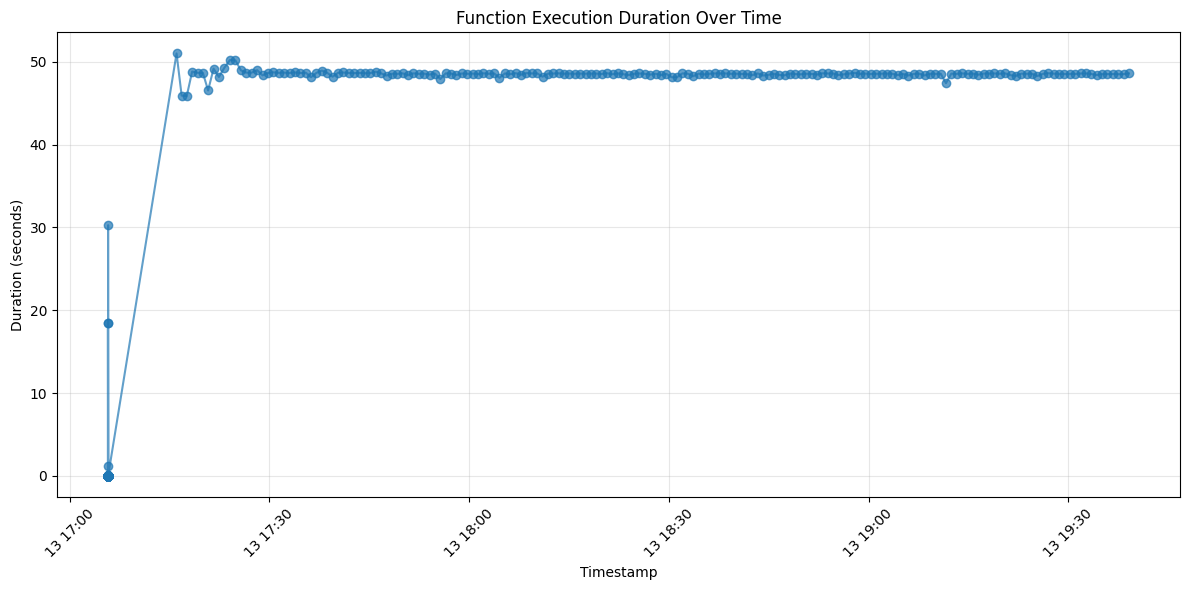

Total execution time: 8704.41 seconds
Average execution time: 7.04 seconds
Longest execution: 50.99 seconds (generate_questions)


In [3]:
if len(logs) > 0:
    # Convert timestamp to datetime for better plotting
    logs["datetime"] = pd.to_datetime(logs["timestamp"], unit="s")
    
    # Plot execution duration over time
    plt.figure(figsize=(12, 6))
    plt.plot(logs["datetime"], logs["duration"], marker="o", alpha=0.7)
    plt.xlabel("Timestamp")
    plt.ylabel("Duration (seconds)")
    plt.title("Function Execution Duration Over Time")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"Total execution time: {logs['duration'].sum():.2f} seconds")
    print(f"Average execution time: {logs['duration'].mean():.2f} seconds")
    print(f"Longest execution: {logs['duration'].max():.2f} seconds ({logs.loc[logs['duration'].idxmax(), 'function_name']})")


## Function Performance Breakdown

Analyze which functions take the most time.


Function Performance Statistics:
------------------------------------------------------------
                                Call Count  Avg Duration (s)  \
function_name                                                  
generate_questions                     887             9.736   
pdf_to_chunks_pipeline                   1            30.264   
load_and_clean_pdf                       1            18.510   
extract_pdf_pages                        1            18.420   
chunk_sections                           1             1.214   
generate_questions_dataset               1             0.093   
normalize_text                         344             0.000   
strip_repeated_headers_footers           1             0.001   

                                Total Duration (s)  Min (s)  Max (s)  
function_name                                                         
generate_questions                        8635.824    0.000   50.988  
pdf_to_chunks_pipeline                      30.264  

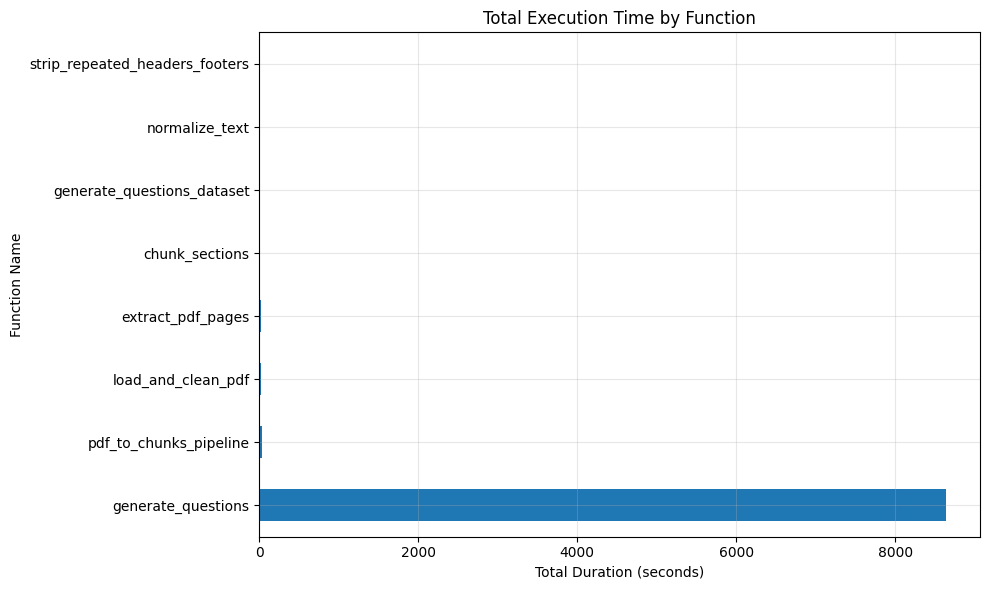

In [4]:
if len(logs) > 0:
    # Group by function name and compute statistics
    function_stats = logs.groupby("function_name")["duration"].agg([
        "count", "mean", "sum", "min", "max"
    ]).round(3)
    function_stats.columns = ["Call Count", "Avg Duration (s)", "Total Duration (s)", "Min (s)", "Max (s)"]
    function_stats = function_stats.sort_values("Total Duration (s)", ascending=False)
    
    print("Function Performance Statistics:")
    print("-" * 60)
    print(function_stats)
    
    # Plot total duration by function
    plt.figure(figsize=(10, 6))
    function_stats["Total Duration (s)"].plot(kind="barh")
    plt.xlabel("Total Duration (seconds)")
    plt.ylabel("Function Name")
    plt.title("Total Execution Time by Function")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## GPU Utilization (if available)

Check GPU usage during training. This helps identify if the GPU is being fully utilized.


In [5]:
# Check GPU availability and utilization
import torch

if torch.cuda.is_available():
    print("GPU Information:")
    print("-" * 40)
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
else:
    print("CUDA not available - using CPU")


GPU Information:
----------------------------------------
GPU 0: NVIDIA GB10
  Memory Allocated: 0.00 GB
  Memory Reserved: 0.00 GB
  Total Memory: 128.53 GB


/home/goble54/spark-dev-workspace/Lora-for-embedding-models/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


## Training Loss Convergence (if available)

If training loss logs are available, visualize loss convergence over epochs.


In [6]:
# Look for training loss files (if saved separately)
# In practice, you might save loss values to a CSV during training
loss_files = glob.glob("outputs/logs/losses_*.csv")

if loss_files:
    latest_loss = max(loss_files, key=Path)
    loss_data = pd.read_csv(latest_loss)
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_data["epoch"], loss_data["loss"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Convergence")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial loss: {loss_data['loss'].iloc[0]:.4f}")
    print(f"Final loss: {loss_data['loss'].iloc[-1]:.4f}")
    print(f"Improvement: {((loss_data['loss'].iloc[0] - loss_data['loss'].iloc[-1]) / loss_data['loss'].iloc[0] * 100):.1f}%")
else:
    print("No training loss logs found. Losses are printed during training in notebook 05.")


No training loss logs found. Losses are printed during training in notebook 05.
